### Relationship between meteorology and balancing costs ###

For a dataset between 1960 and 2023 (likely with non-linear trends, the influence of covid and ukraine war), we want to understand the relationship between meteorology and balancing costs.

In [1]:
%matplotlib inline

# import local modules
import sys
import os
import re
import glob
import time

# import third party modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set up the hard coded variables
bsuos_data_rf_path = "/home/users/benhutch/energy-sotcr-2024-2025/data/2016-2023-rf.csv"

In [3]:
# Import the data
bsuos_data_rf = pd.read_csv(bsuos_data_rf_path)

In [4]:
bsuos_data_rf.columns

Index(['Settlement Day', 'Settlement Period', 'BSUoS Price (£/MWh Hour)',
       'Half-hourly Charge', 'Total Daily BSUoS Charge', 'Run Type'],
      dtype='object')

In [5]:
# Strip any leading or trailing whitespace from the 'Settlement Day' column
bsuos_data_rf['Settlement Day'] = bsuos_data_rf['Settlement Day'].str.strip()

# Convert 'Settlement Day' to datetime
bsuos_data_rf['Settlement Day'] = pd.to_datetime(bsuos_data_rf['Settlement Day'], format='%Y-%m-%dT%H:%M:%S')

In [6]:
# Create a new column for Settlement Day Time in the format yyyy-mm-dd hh:mm:ss
# Calculate the time from 'Settlement Period'
bsuos_data_rf['Settlement Time'] = (bsuos_data_rf['Settlement Period'] - 1) * pd.Timedelta(minutes=30)

# Combine 'Settlement Day' and 'Settlement Time' to create 'Settlement Datetime'
bsuos_data_rf['Settlement Datetime'] = bsuos_data_rf['Settlement Day'] + bsuos_data_rf['Settlement Time']

# Drop the 'Settlement Time' column as it's no longer needed
bsuos_data_rf.drop(columns=['Settlement Time'], inplace=True)

In [7]:
# subset all of the data to months 10, 11, 12, 1, 2, 3
bsuos_data_rf = bsuos_data_rf[bsuos_data_rf['Settlement Day'].dt.month.isin([10, 11, 12, 1, 2, 3])]

In [8]:
# aggregate the data into daily averages
bsuos_data_rf_daily = bsuos_data_rf.groupby('Settlement Day').agg({'Total Daily BSUoS Charge': 'sum'}).reset_index()

In [9]:
bsuos_data_rf_daily.head()

,Settlement Day,Total Daily BSUoS Charge
0,2016-10-01,1.450115e+08
1,2016-10-02,1.476938e+08
2,2016-10-03,1.078372e+08
3,2016-10-04,1.412437e+08
4,2016-10-05,1.915845e+08


In [10]:
# set the index to 'Settlement Day'
# first make sure is datetime
bsuos_data_rf_daily['Settlement Day'] = pd.to_datetime(bsuos_data_rf_daily['Settlement Day'])

# set the index
bsuos_data_rf_daily.set_index('Settlement Day', inplace=True)

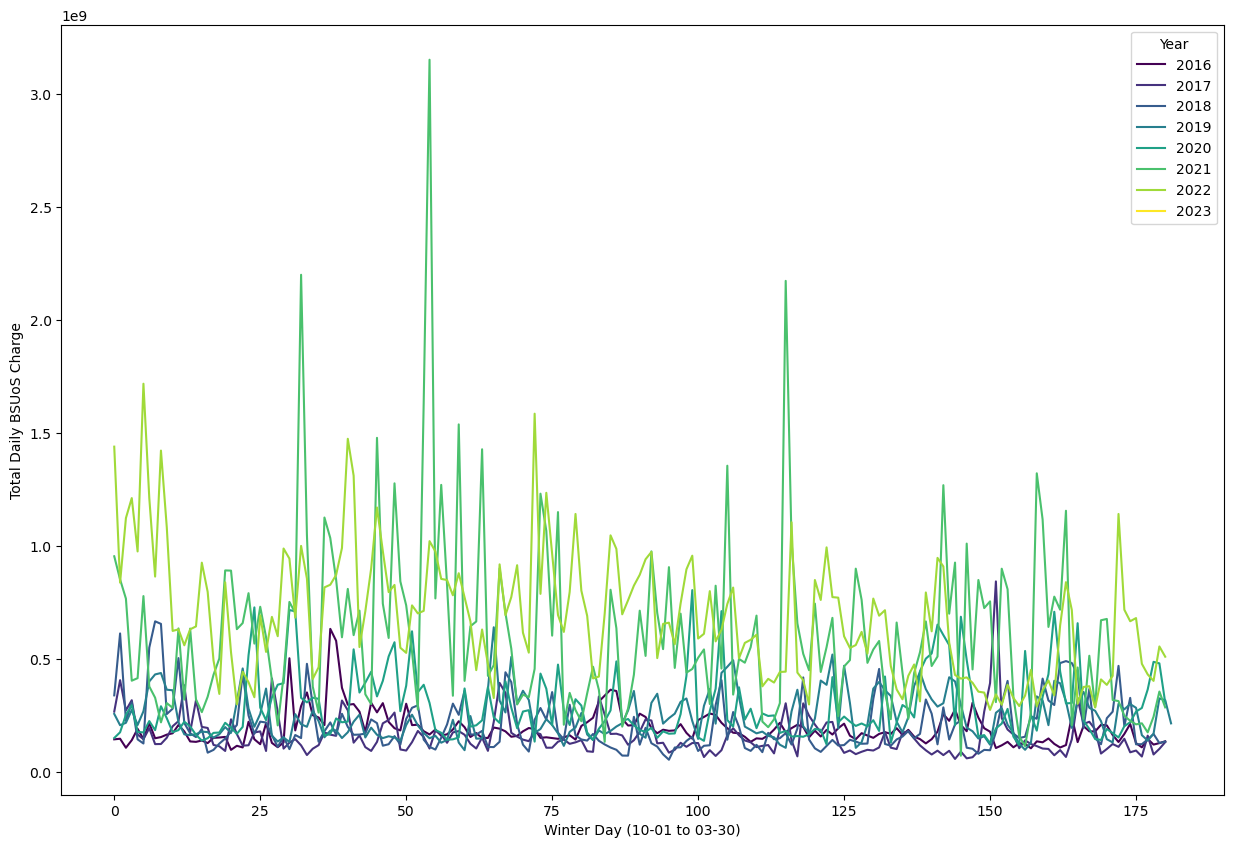

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming bsuos_data_rf_daily is already defined and has a DateTime index

# Define the winter period
winter_start = '10-01'
winter_end = '03-30'

# Create a figure
fig, ax = plt.subplots(figsize=(15, 10))

# Get a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(bsuos_data_rf_daily.index.year.unique())))

# Loop over the unique years in the data
for i, year in enumerate(bsuos_data_rf_daily.index.year.unique()):
    # Subset the data to the current year
    bsuos_data_rf_daily_year_OND = bsuos_data_rf_daily[(bsuos_data_rf_daily.index.year == year) & (bsuos_data_rf_daily.index.strftime('%m-%d') >= winter_start)]
    
    # Find the other part for JFM
    bsuos_data_rf_daily_year_JFM = bsuos_data_rf_daily[(bsuos_data_rf_daily.index.year == year + 1) & (bsuos_data_rf_daily.index.strftime('%m-%d') <= winter_end)]
    
    # Combine the two dataframes
    bsuos_data_rf_daily_year = pd.concat([bsuos_data_rf_daily_year_OND, bsuos_data_rf_daily_year_JFM])
    
    # Create a custom x-axis for the winter period
    bsuos_data_rf_daily_year['Winter Day'] = np.arange(len(bsuos_data_rf_daily_year))
    
    # Plot the data with a different color for each year
    ax.plot(bsuos_data_rf_daily_year['Winter Day'], bsuos_data_rf_daily_year['Total Daily BSUoS Charge'], label=year, color=colors[i])

# Add legend
ax.legend(title='Year')

# Set x-axis labels
ax.set_xlabel('Winter Day (10-01 to 03-30)')
ax.set_ylabel('Total Daily BSUoS Charge')

# Show the plot
plt.show()

In [12]:
# Define the winter period
winter_start = '10-01'
winter_end = '03-30'

# Loop over the unique years in the data
for year in bsuos_data_rf_daily.index.year.unique():
    # Subset the data to the current year
    bsuos_data_rf_daily_year_OND = bsuos_data_rf_daily[(bsuos_data_rf_daily.index.year == year) & (bsuos_data_rf_daily.index.strftime('%m-%d') >= winter_start)]
    bsuos_data_rf_daily_year_JFM = bsuos_data_rf_daily[(bsuos_data_rf_daily.index.year == year + 1) & (bsuos_data_rf_daily.index.strftime('%m-%d') <= winter_end)]
    bsuos_data_rf_daily_year = pd.concat([bsuos_data_rf_daily_year_OND, bsuos_data_rf_daily_year_JFM])
    
    # Calculate the mean and standard deviation for the winter period
    bsuos_data_rf_daily_year_mean = bsuos_data_rf_daily_year['Total Daily BSUoS Charge'].mean()
    bsuos_data_rf_daily_year_std = bsuos_data_rf_daily_year['Total Daily BSUoS Charge'].std()
    
    # Calculate the anomaly for the winter period
    bsuos_data_rf_daily_year['Anomaly'] = bsuos_data_rf_daily_year['Total Daily BSUoS Charge'] - bsuos_data_rf_daily_year_mean
    
    # Normalize the anomaly
    bsuos_data_rf_daily_year['Normalized Anomaly'] = bsuos_data_rf_daily_year['Anomaly'] / bsuos_data_rf_daily_year_std
    
    # Add the normalized anomaly to the original dataframe
    bsuos_data_rf_daily.loc[bsuos_data_rf_daily_year.index, 'Normalized Anomaly'] = bsuos_data_rf_daily_year['Normalized Anomaly']

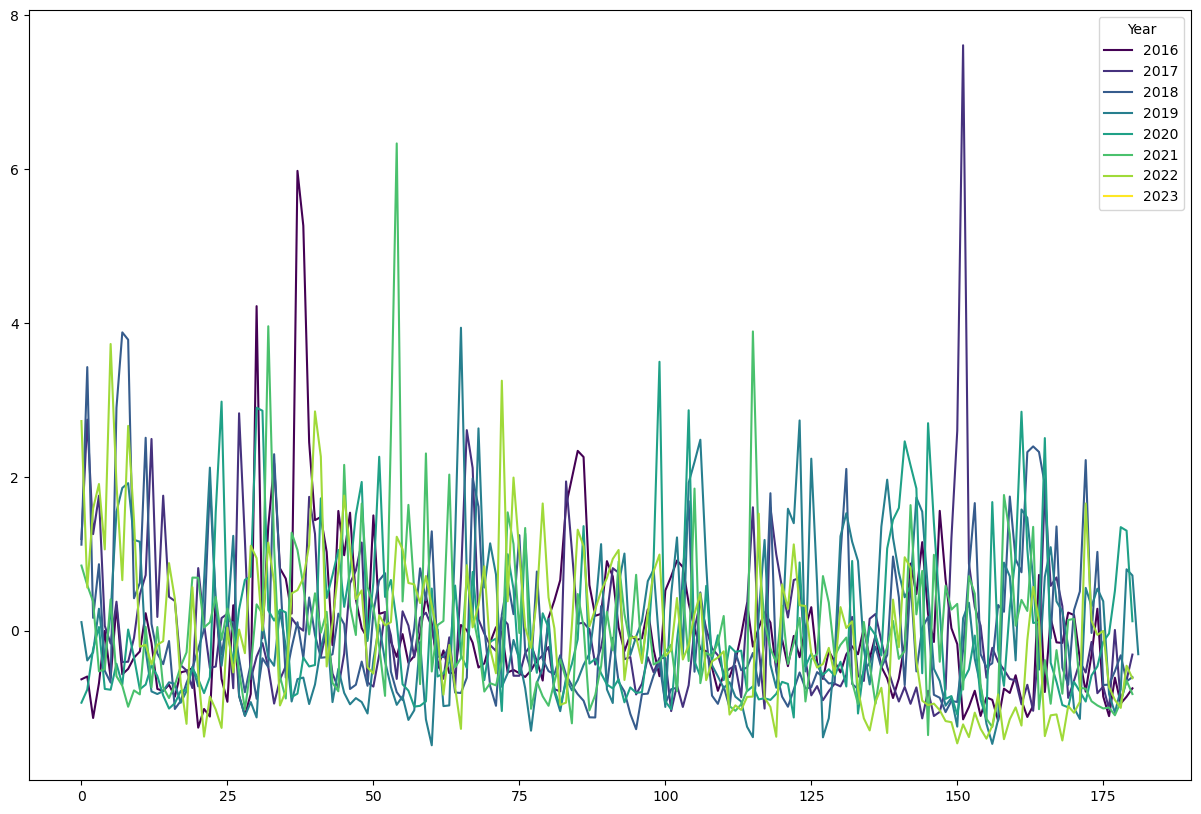

In [13]:
# now plot the anomalies for each winter
# Create a figure
fig, ax = plt.subplots(figsize=(15, 10))

# Loop over the unique years in the data
for i, year in enumerate(bsuos_data_rf_daily.index.year.unique()):
    # Subset the data to the current year
    bsuos_data_rf_daily_year_OND = bsuos_data_rf_daily[(bsuos_data_rf_daily.index.year == year) & (bsuos_data_rf_daily.index.strftime('%m-%d') >= winter_start)]
    bsuos_data_rf_daily_year_JFM = bsuos_data_rf_daily[(bsuos_data_rf_daily.index.year == year + 1) & (bsuos_data_rf_daily.index.strftime('%m-%d') <= winter_end)]
    bsuos_data_rf_daily_year = pd.concat([bsuos_data_rf_daily_year_OND, bsuos_data_rf_daily_year_JFM])
    
    # Create a custom x-axis for the winter period
    bsuos_data_rf_daily_year['Winter Day'] = np.arange(len(bsuos_data_rf_daily_year))
    
    # Plot the data with a different color for each year
    ax.plot(bsuos_data_rf_daily_year['Winter Day'], bsuos_data_rf_daily_year['Normalized Anomaly'], label=year, color=colors[i])

# Add legend
ax.legend(title='Year')

In [14]:
# print the day with the largest spike
max_spike = bsuos_data_rf_daily['Normalized Anomaly'].idxmax()

print(f'The day with the largest spike in BSUoS charge is {max_spike.strftime("%Y-%m-%d")} with a value of {bsuos_data_rf_daily.loc[max_spike, "Normalized Anomaly"]}')

The day with the largest spike in BSUoS charge is 2018-03-01 with a value of 7.612008444148938


In [15]:
# set up the fpath to the met dataframe
met_df_path = "/home/users/benhutch/energy-sotcr-2023/data/ERA5_UK_1940_2024_daily_SP_WP_demand_wind.csv"

# Import the data
met_df = pd.read_csv(met_df_path)

In [16]:
met_df.tail()

,date,United_Kingdom_solar_cf,United_Kingdom_wind_cf,United_Kingdom_demand,United_Kingdom_wd_demand,UK_wind_speed,UK_temp,United_Kingdom_wind_gen,demand_net_wind,wd_demand_net_wind
30797,2024-04-26,NaN,0.074094,NaN,42.329561,4.982702,5.864006,2.194816,NaN,40.134745
30798,2024-04-27,NaN,0.169378,NaN,41.950943,4.626178,6.370445,5.017321,NaN,36.933622
30799,2024-04-28,NaN,0.423680,NaN,41.484416,6.568364,6.994470,12.550235,NaN,28.934180
30800,2024-04-29,NaN,0.636219,NaN,39.776280,9.420220,9.279269,18.846072,NaN,20.930208
30801,2024-04-30,NaN,0.538781,NaN,NaN,9.209826,NaN,15.959784,NaN,NaN


In [17]:
bsuos_data_rf_daily.head()

,Total Daily BSUoS Charge,Normalized Anomaly
Settlement Day,,
2016-10-01,1.450115e+08,-0.630184
2016-10-02,1.476938e+08,-0.593930
2016-10-03,1.078372e+08,-1.132624
2016-10-04,1.412437e+08,-0.681109
2016-10-05,1.915845e+08,-0.000714


In [18]:
# Convert 'date' column in met_df to datetime if not already done
met_df['date'] = pd.to_datetime(met_df['date'])

# Ensure the index of bsuos_data_rf_daily is datetime
bsuos_data_rf_daily.index = pd.to_datetime(bsuos_data_rf_daily.index)

# Remove time components from the datetime index if not needed
met_df['date'] = met_df['date'].dt.normalize()
bsuos_data_rf_daily.index = bsuos_data_rf_daily.index.normalize()

# Limit met data to the same period as the bsuos data
met_df = met_df[met_df['date'].isin(bsuos_data_rf_daily.index)]

# Set date as the index
met_df.set_index('date', inplace=True)

# Join the two dataframes
bsuos_met_df = bsuos_data_rf_daily.join(met_df)

# Check for any issues
print(bsuos_met_df.head())
print(bsuos_met_df.tail())

                Total Daily BSUoS Charge  Normalized Anomaly  \
Settlement Day                                                 
2016-10-01                  1.450115e+08           -0.630184   
2016-10-02                  1.476938e+08           -0.593930   
2016-10-03                  1.078372e+08           -1.132624   
2016-10-04                  1.412437e+08           -0.681109   
2016-10-05                  1.915845e+08           -0.000714   

                United_Kingdom_solar_cf  United_Kingdom_wind_cf  \
Settlement Day                                                    
2016-10-01                     0.019811                0.091710   
2016-10-02                     0.054237                0.303636   
2016-10-03                     0.077049                0.415352   
2016-10-04                     0.139224                0.611945   
2016-10-05                     0.151449                0.707761   

                United_Kingdom_demand  United_Kingdom_wd_demand  \
Settlement Day

In [19]:
bsuos_met_df.tail()

,Total Daily BSUoS Charge,Normalized Anomaly,United_Kingdom_solar_cf,United_Kingdom_wind_cf,United_Kingdom_demand,United_Kingdom_wd_demand,UK_wind_speed,UK_temp,United_Kingdom_wind_gen,demand_net_wind,wd_demand_net_wind
Settlement Day,,,,,,,,,,,
2023-03-27,4.324249e+08,-0.898396,0.131826,0.215109,42.703597,43.511867,5.418902,4.282556,6.371969,36.331628,37.139898
2023-03-28,4.036636e+08,-1.001829,0.039538,0.501557,41.946086,41.946086,8.742680,6.376941,14.857119,27.088967,27.088967
2023-03-29,5.561583e+08,-0.453420,0.040899,0.585835,39.296558,39.296558,9.589533,9.920945,17.353593,21.942965,21.942965
2023-03-30,5.107427e+08,-0.616746,0.104990,0.486342,38.925149,38.925149,8.774807,10.417741,14.406435,24.518714,24.518714
2023-03-31,4.613044e+08,NaN,0.057646,0.469847,39.089271,39.989013,8.669594,8.994718,13.917802,25.171468,26.071211


In [20]:
# calculate the corr for the df
corr = bsuos_met_df.corr()

In [21]:
corr

,Total Daily BSUoS Charge,Normalized Anomaly,United_Kingdom_solar_cf,United_Kingdom_wind_cf,United_Kingdom_demand,United_Kingdom_wd_demand,UK_wind_speed,UK_temp,United_Kingdom_wind_gen,demand_net_wind,wd_demand_net_wind
Total Daily BSUoS Charge,1.000000,0.602522,-0.022702,0.272875,-0.121927,-0.160816,0.277166,0.160816,0.272875,-0.281629,-0.291915
Normalized Anomaly,0.602522,1.000000,-0.036816,0.507341,-0.141118,-0.172453,0.525375,0.172453,0.507341,-0.489671,-0.501797
United_Kingdom_solar_cf,-0.022702,-0.036816,1.000000,-0.072524,0.023991,0.026708,-0.076132,-0.026708,-0.072524,0.071537,0.072419
United_Kingdom_wind_cf,0.272875,0.507341,-0.072524,1.000000,-0.166045,-0.215130,0.980936,0.215130,1.000000,-0.921497,-0.949215
United_Kingdom_demand,-0.121927,-0.141118,0.023991,-0.166045,1.000000,0.791605,-0.156045,-0.791605,-0.166045,0.536004,0.401136
United_Kingdom_wd_demand,-0.160816,-0.172453,0.026708,-0.215130,0.791605,1.000000,-0.194282,-1.000000,-0.215130,0.495948,0.511465
UK_wind_speed,0.277166,0.525375,-0.076132,0.980936,-0.156045,-0.194282,1.000000,0.194282,0.980936,-0.901237,-0.925724
UK_temp,0.160816,0.172453,-0.026708,0.215130,-0.791605,-1.000000,0.194282,1.000000,0.215130,-0.495948,-0.511465
United_Kingdom_wind_gen,0.272875,0.507341,-0.072524,1.000000,-0.166045,-0.215130,0.980936,0.215130,1.000000,-0.921497,-0.949215
demand_net_wind,-0.281629,-0.489671,0.071537,-0.921497,0.536004,0.495948,-0.901237,-0.495948,-0.921497,1.000000,0.970611


In [22]:
# strip the df of nan rows
bsuos_met_df = bsuos_met_df.dropna()

In [23]:
# construct a MLR to map UK_wind_speed and UK_temp to normalized anomaly
from sklearn.linear_model import LinearRegression

# import tghe r2_score and mean_squared_error functions
from sklearn.metrics import r2_score, mean_squared_error

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(bsuos_met_df[['UK_wind_speed', 'UK_temp']], bsuos_met_df['Normalized Anomaly'])

# Print the coefficients
print(f'Wind speed coefficient: {model.coef_[0]}')
print(f'Temperature coefficient: {model.coef_[1]}')

# Calculate the predicted normalized anomaly
bsuos_met_df['Predicted Normalized Anomaly'] = model.predict(bsuos_met_df[['UK_wind_speed', 'UK_temp']])

Wind speed coefficient: 0.1890875155056008
Temperature coefficient: 0.022732882868366104


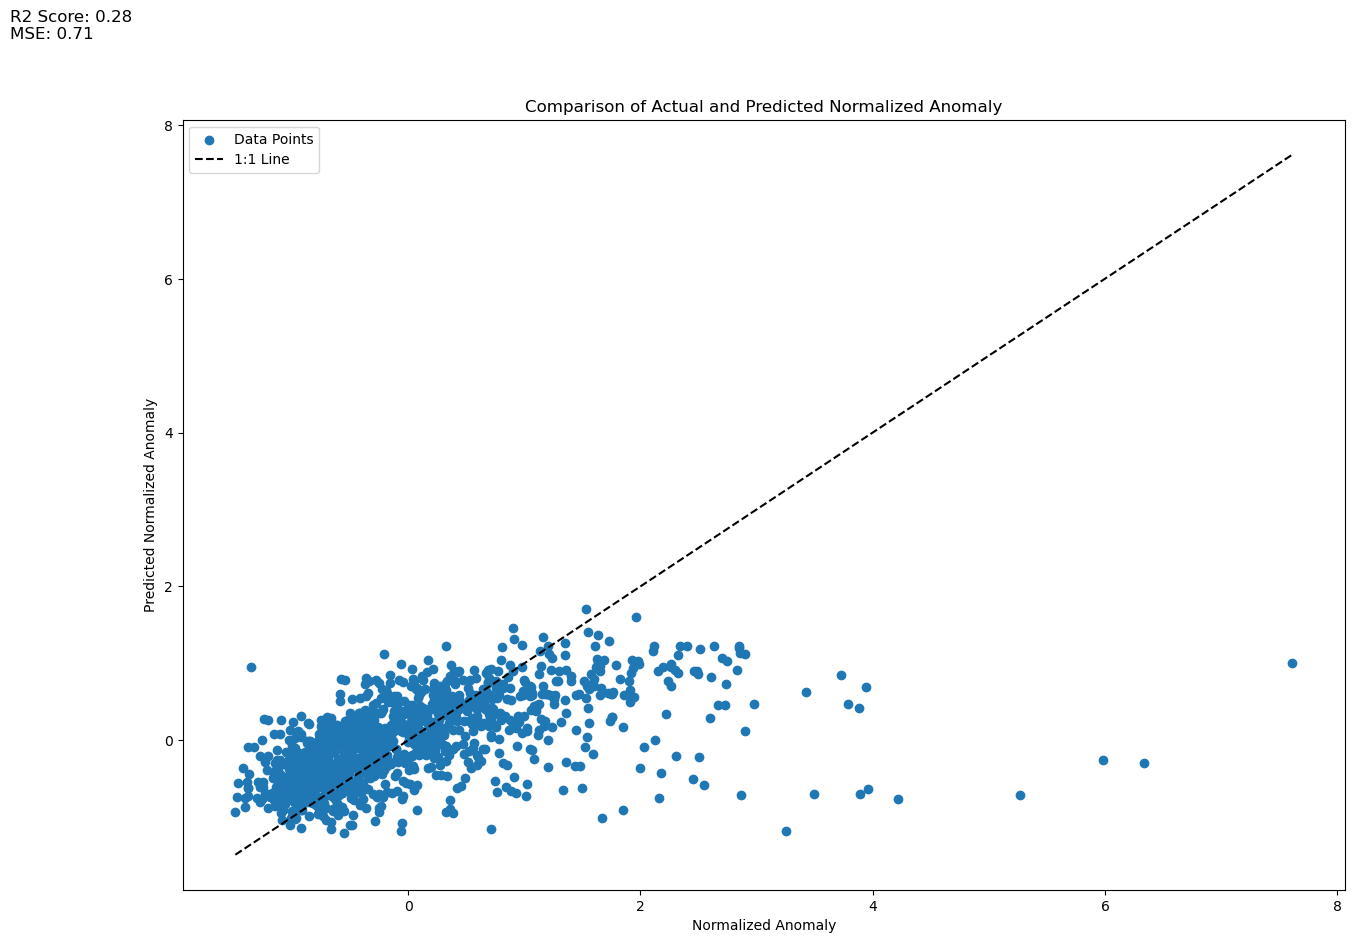

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Plot the predicted normalized anomaly against the actual normalized anomaly
fig, ax = plt.subplots(figsize=(15, 10))

# plot a scatter of the actual vs predicted
ax.scatter(bsuos_met_df['Normalized Anomaly'], bsuos_met_df['Predicted Normalized Anomaly'], label='Data Points')

# Add a 1:1 line for verification
min_val = min(bsuos_met_df['Normalized Anomaly'].min(), bsuos_met_df['Predicted Normalized Anomaly'].min())
max_val = max(bsuos_met_df['Normalized Anomaly'].max(), bsuos_met_df['Predicted Normalized Anomaly'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# calculate the R2 score
r2 = r2_score(bsuos_met_df['Normalized Anomaly'], bsuos_met_df['Predicted Normalized Anomaly'])

# calculate the Mean Squared Error
mse = mean_squared_error(bsuos_met_df['Normalized Anomaly'], bsuos_met_df['Predicted Normalized Anomaly'])

# include the error metrics in a textbox in the top left
fig.text(0.01, 0.99, f'R2 Score: {r2:.2f}\nMSE: {mse:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=12)

# include a title
plt.title('Comparison of Actual and Predicted Normalized Anomaly')

# Add labels and legend
ax.set_xlabel('Normalized Anomaly')
ax.set_ylabel('Predicted Normalized Anomaly')
ax.legend()

# show the plot
plt.show()

In [25]:
# just try a simple linear regression based on the wind speed
# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(bsuos_met_df[['UK_wind_speed']], bsuos_met_df['Normalized Anomaly'])

# Print the coefficients
print(f'Wind speed coefficient: {model.coef_[0]}')

# Calculate the predicted normalized anomaly
bsuos_met_df['Predicted Normalized Anomaly'] = model.predict(bsuos_met_df[['UK_wind_speed']])

Wind speed coefficient: 0.19432865439562746


Text(0.5, 1.0, 'Comparison of Actual and Predicted Normalized Anomaly')

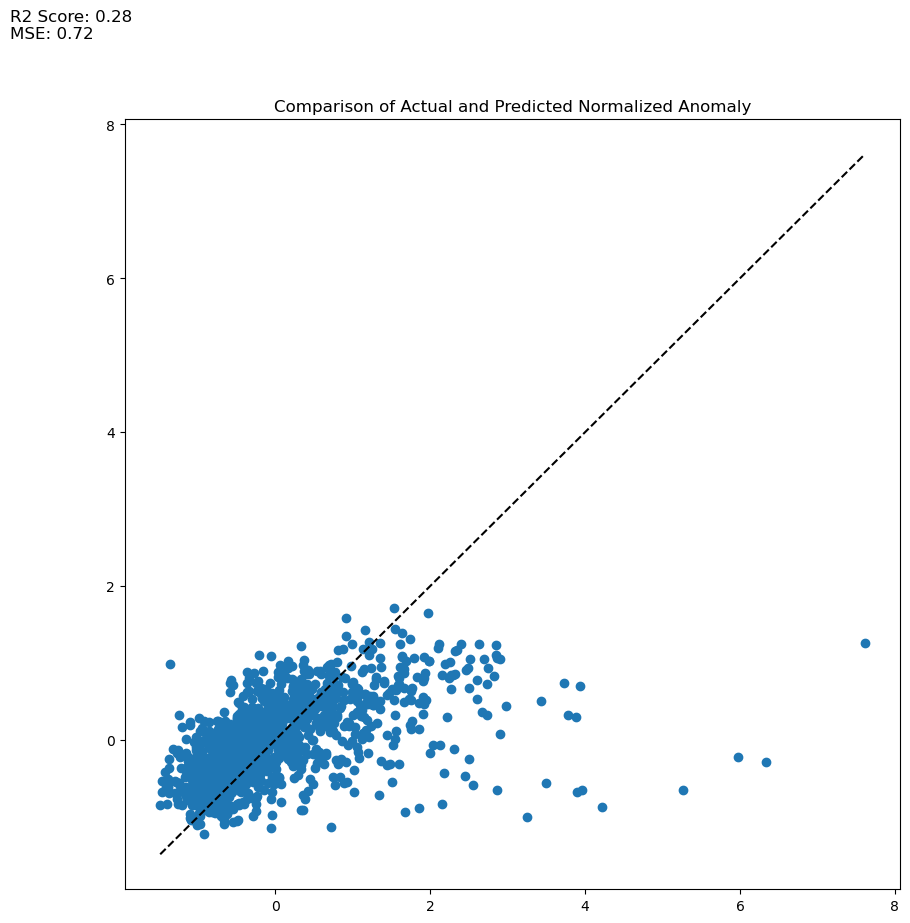

In [26]:
# Plot the predicted normalized anomaly against the actual normalized anomaly
fig, ax = plt.subplots(figsize=(10, 10))

# plot a scatter of the actual vs predicted
ax.scatter(bsuos_met_df['Normalized Anomaly'], bsuos_met_df['Predicted Normalized Anomaly'], label='Data Points')

# Add a 1:1 line for verification
min_val = min(bsuos_met_df['Normalized Anomaly'].min(), bsuos_met_df['Predicted Normalized Anomaly'].min())

max_val = max(bsuos_met_df['Normalized Anomaly'].max(), bsuos_met_df['Predicted Normalized Anomaly'].max())

ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# calculate the R2 score
r2 = r2_score(bsuos_met_df['Normalized Anomaly'], bsuos_met_df['Predicted Normalized Anomaly'])

# calculate the Mean Squared Error

mse = mean_squared_error(bsuos_met_df['Normalized Anomaly'], bsuos_met_df['Predicted Normalized Anomaly'])

# include the error metrics in a textbox in the top left
fig.text(0.01, 0.99, f'R2 Score: {r2:.2f}\nMSE: {mse:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=12)

# include a title
plt.title('Comparison of Actual and Predicted Normalized Anomaly')

In [27]:
# Set up the percentiles
# Set up the 1 %tile bins for demand
high_res_percentile = np.arange(1, 100, 1)

# Initialize an empty dataframe
bsuos_met_df_percentiles = pd.DataFrame()

# Loop over the percentiles
for percentile in high_res_percentile:
    # Calculate the threshold for the daily price at this percentile
    threshold = np.percentile(bsuos_met_df['Normalized Anomaly'], percentile)

    # subset the df to days where the price is above the threshold
    bsuos_met_df_percentile = bsuos_met_df[bsuos_met_df['Normalized Anomaly'] >= threshold]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            'Percentile': percentile,
            'Normalized Anomaly': threshold,
            'Mean Price': bsuos_met_df_percentile['Total Daily BSUoS Charge'].mean(),
            'Mean UK_wind_speed': bsuos_met_df_percentile['UK_wind_speed'].mean(),
            'Mean UK_temp': bsuos_met_df_percentile['UK_temp'].mean(),
            'Count': bsuos_met_df_percentile.shape[0]
        },
        index=[0]
    )

    # Append the new dataframe to the main dataframe
    bsuos_met_df_percentiles = pd.concat([bsuos_met_df_percentiles, df_this])

In [28]:
bsuos_met_df_percentiles.tail()

,Percentile,Normalized Anomaly,Mean Price,Mean UK_wind_speed,Mean UK_temp,Count
0,95,1.921224,7.844099e+08,11.547428,7.697332,64
0,96,2.152953,8.364191e+08,11.173465,7.788579,51
0,97,2.339446,8.753999e+08,11.015697,7.806439,39
0,98,2.687456,9.945233e+08,10.478937,7.777080,26
0,99,3.310014,1.168847e+09,9.041407,6.874214,13


Text(0, 0.5, 'UK mean wind speed')

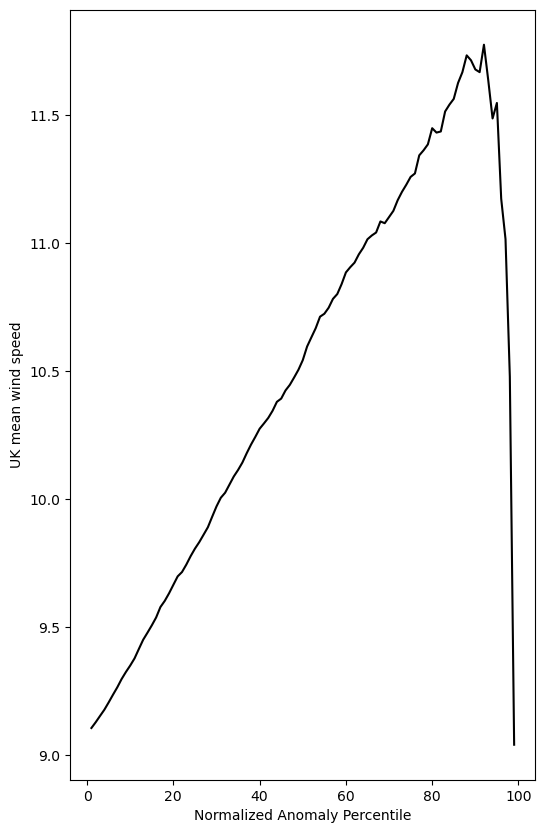

In [29]:
# plot the normalized anomaly percintles on the x-axis against the mean uk wind speed
fig, ax = plt.subplots(figsize=(6, 10))

# plot the demand percentile on trhe x-axis
ax.plot(
    bsuos_met_df_percentiles["Percentile"],
    bsuos_met_df_percentiles["Mean UK_wind_speed"],
    label="obs",
    color="black",
    linestyle="-",
)

# # plot the demand percentile on trhe x-axis
# ax.plot(
#     df_demand_percentiles_high_res["percentile"],
#     df_demand_percentiles_high_res["mean_wind_model"],
#     label="model",
#     color="red",
#     linestyle="-",
# )

# set the labels
ax.set_xlabel("Normalized Anomaly Percentile")

# set the labels
ax.set_ylabel("UK mean wind speed")

Text(0, 0.5, 'UK mean temperature')

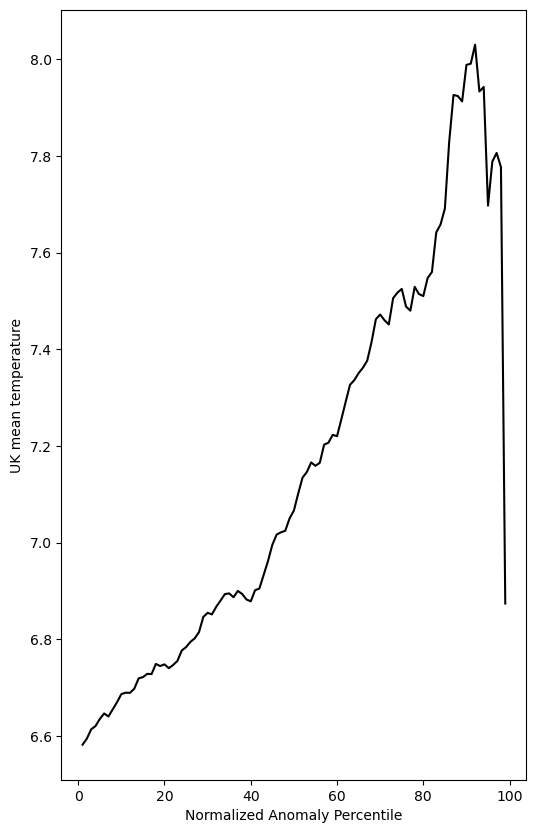

In [30]:
# do the same but for normalized anomaly and mean uk temp
fig, ax = plt.subplots(figsize=(6, 10))

# plot the demand percentile on trhe x-axis
ax.plot(
    bsuos_met_df_percentiles["Percentile"],
    bsuos_met_df_percentiles["Mean UK_temp"],
    label="obs",
    color="black",
    linestyle="-",
)

# # plot the demand percentile on trhe x-axis
# ax.plot(
#     df_demand_percentiles_high_res["percentile"],
#     df_demand_percentiles_high_res["mean_wind_model"],
#     label="model",
#     color="red",
#     linestyle="-",
# )

# set the labels
ax.set_xlabel("Normalized Anomaly Percentile")

# set the labels
ax.set_ylabel("UK mean temperature")

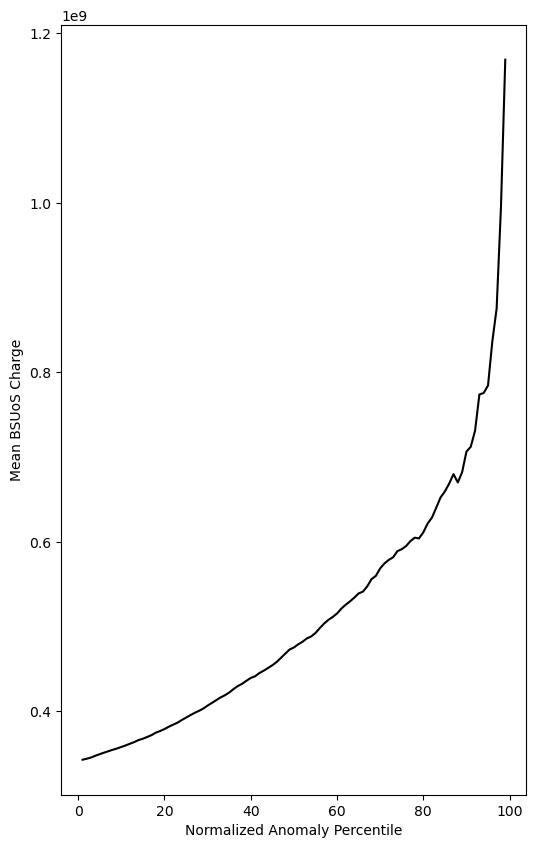

In [31]:
# do the same but for normalized anomaly and mean price
fig, ax = plt.subplots(figsize=(6, 10))

# plot the demand percentile on trhe x-axis
ax.plot(
    bsuos_met_df_percentiles["Percentile"],
    bsuos_met_df_percentiles["Mean Price"],
    label="obs",
    color="black",
    linestyle="-",
)

# set the axis labels
ax.set_xlabel("Normalized Anomaly Percentile")

# set the axis labels
ax.set_ylabel("Mean BSUoS Charge")

# show the plot
plt.show()

In [32]:
# subset the dataframe to above the 90th percentile
bsuos_met_df_percentiles_90 = bsuos_met_df_percentiles[bsuos_met_df_percentiles['Percentile'] >= 90]

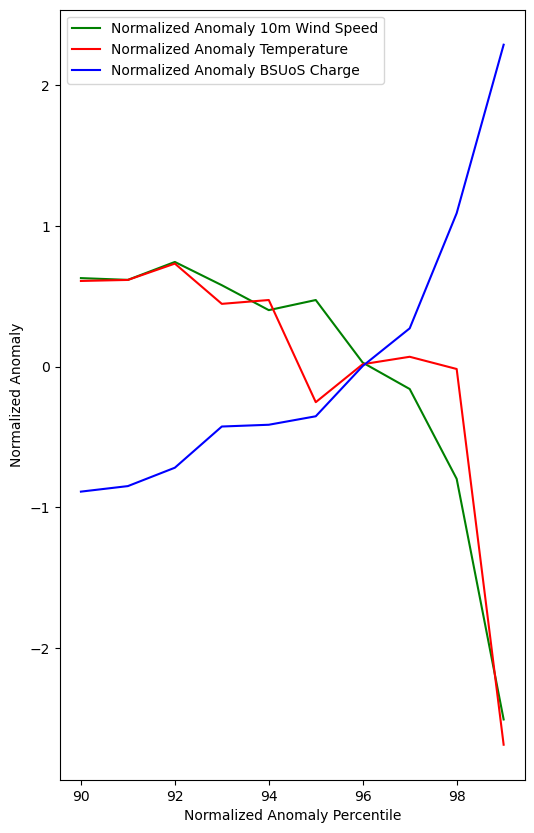

In [33]:
# plot the normalized anomaly percentiles on the x-axis against the mean UK wind speed
# but the mean UK wind speed is presented as standardized anomalies
fig, ax = plt.subplots(figsize=(6, 10))

# plot the demand percentile on the x-axis
ax.plot(
    bsuos_met_df_percentiles_90["Percentile"],
    (bsuos_met_df_percentiles_90["Mean UK_wind_speed"] - bsuos_met_df_percentiles_90["Mean UK_wind_speed"].mean()) / bsuos_met_df_percentiles_90["Mean UK_wind_speed"].std(),
    label="Normalized Anomaly 10m Wind Speed",
    color="green",
    linestyle="-",
)

# plot the demand percentile on the x-axis
ax.plot(
    bsuos_met_df_percentiles_90["Percentile"],
    (bsuos_met_df_percentiles_90["Mean UK_temp"] - bsuos_met_df_percentiles_90["Mean UK_temp"].mean()) / bsuos_met_df_percentiles_90["Mean UK_temp"].std(),
    label="Normalized Anomaly Temperature",
    color="red",
    linestyle="-",
)

# plot the mean price
ax.plot(
    bsuos_met_df_percentiles_90["Percentile"],
    (bsuos_met_df_percentiles_90["Mean Price"] - bsuos_met_df_percentiles_90["Mean Price"].mean()) / bsuos_met_df_percentiles_90["Mean Price"].std(),
    label="Normalized Anomaly BSUoS Charge",
    color="blue",
    linestyle="-",
)

# set the labels
ax.set_xlabel("Normalized Anomaly Percentile")

# set the labels
ax.set_ylabel("Normalized Anomaly")

# Include a legend
ax.legend()

# show the plot
plt.show()


In [34]:
# calculate the correlation in the 90 df
corr = bsuos_met_df_percentiles_90.corr()

corr

,Percentile,Normalized Anomaly,Mean Price,Mean UK_wind_speed,Mean UK_temp,Count
Percentile,1.000000,0.956473,0.889320,-0.811486,-0.723313,-0.999971
Normalized Anomaly,0.956473,1.000000,0.981296,-0.944025,-0.859059,-0.957296
Mean Price,0.889320,0.981296,1.000000,-0.982897,-0.892612,-0.890768
Mean UK_wind_speed,-0.811486,-0.944025,-0.982897,1.000000,0.930832,0.813132
Mean UK_temp,-0.723313,-0.859059,-0.892612,0.930832,1.000000,0.725626
Count,-0.999971,-0.957296,-0.890768,0.813132,0.725626,1.000000


In [35]:
bsuos_met_df_percentiles_90["Count"].sum()

np.int64(703)

In [36]:
# set up the percentile threshold
percentile_threshold = 95

# limit the bsuos_met_df to where normalized anomaly is above the threshold
bsuos_met_df_percentile_threshold = bsuos_met_df[bsuos_met_df['Normalized Anomaly'] >= np.percentile(bsuos_met_df['Normalized Anomaly'], percentile_threshold)]

In [37]:
bsuos_met_df_percentile_threshold.shape

(64, 12)

In [38]:
# now construct a MLR for normalized anomaly based on wind speed and tgemp
# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(bsuos_met_df_percentile_threshold[['UK_wind_speed', 'UK_temp']], bsuos_met_df_percentile_threshold['Normalized Anomaly'])

# Print the coefficients
print(f'Wind speed coefficient: {model.coef_[0]}')
print(f'Temperature coefficient: {model.coef_[1]}')

# Calculate the predicted normalized anomaly
bsuos_met_df_percentile_threshold['Predicted Normalized Anomaly Perc'] = model.predict(bsuos_met_df_percentile_threshold[['UK_wind_speed', 'UK_temp']])

Wind speed coefficient: -0.07030038938063461
Temperature coefficient: -0.04913792310252607


/tmp/ipykernel_83766/753152419.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsuos_met_df_percentile_threshold['Predicted Normalized Anomaly Perc'] = model.predict(bsuos_met_df_percentile_threshold[['UK_wind_speed', 'UK_temp']])


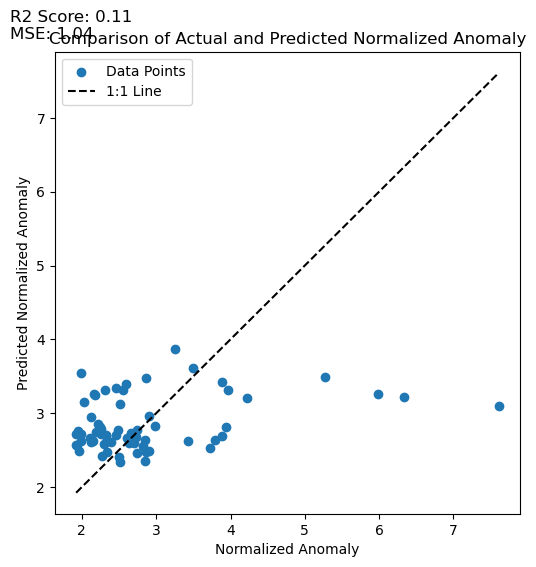

In [39]:
# set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# plot the actual vs predicted normalized anomaly
ax.scatter(bsuos_met_df_percentile_threshold['Normalized Anomaly'], bsuos_met_df_percentile_threshold['Predicted Normalized Anomaly Perc'], label='Data Points')

# Add a 1:1 line for verification
min_val = min(bsuos_met_df_percentile_threshold['Normalized Anomaly'].min(), bsuos_met_df_percentile_threshold['Predicted Normalized Anomaly Perc'].min())
max_val = max(bsuos_met_df_percentile_threshold['Normalized Anomaly'].max(), bsuos_met_df_percentile_threshold['Predicted Normalized Anomaly Perc'].max())

ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# calculate the R2 score
r2 = r2_score(bsuos_met_df_percentile_threshold['Normalized Anomaly'], bsuos_met_df_percentile_threshold['Predicted Normalized Anomaly Perc'])

# calculate the Mean Squared Error
mse = mean_squared_error(bsuos_met_df_percentile_threshold['Normalized Anomaly'], bsuos_met_df_percentile_threshold['Predicted Normalized Anomaly Perc'])

# include the error metrics in a textbox in the top left
fig.text(0.05, 0.95, f'R2 Score: {r2:.2f}\nMSE: {mse:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=12)

# include a title
plt.title('Comparison of Actual and Predicted Normalized Anomaly')

# Add labels and legend
ax.set_xlabel('Normalized Anomaly')

# Add labels and legend
ax.set_ylabel('Predicted Normalized Anomaly')

# Add labels and legend
ax.legend()


In [45]:
# rename all of the columns in the bsuos_met_df_percentile_threshold
# to have _ in place of spaces
bsuos_met_df_percentile_threshold.columns = [col.replace(' ', '_') for col in bsuos_met_df_percentile_threshold.columns]

                 Generalized Linear Model Regression Results                  
Dep. Variable:     Normalized_Anomaly   No. Observations:                   64
Model:                            GLM   Df Residuals:                       62
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                         0.13815
Method:                          IRLS   Log-Likelihood:                -81.262
Date:                Fri, 24 Jan 2025   Deviance:                       5.8673
Time:                        14:25:11   Pearson chi2:                     8.57
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07641
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2371      0.050      4.721

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


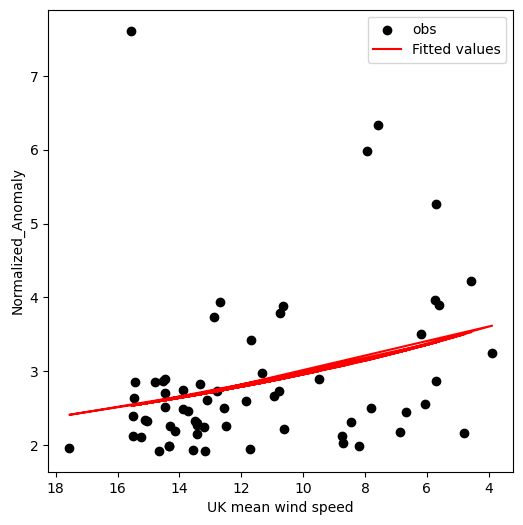

In [46]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Fit a GLM with a gamma distribution
formula = 'Normalized_Anomaly ~ UK_wind_speed'
model = smf.glm(formula=formula, data=bsuos_met_df_percentile_threshold, family=sm.families.Gamma()).fit()

# Print the model summary
print(model.summary())

# Plot the normalized anomaly values on the y-axis against the mean UK wind speed on the x-axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot of the actual data
ax.scatter(
    bsuos_met_df_percentile_threshold["UK_wind_speed"],
    bsuos_met_df_percentile_threshold["Normalized_Anomaly"],
    label="obs",
    color="black"
)

# Plot the fitted values
ax.plot(
    bsuos_met_df_percentile_threshold["UK_wind_speed"],
    model.fittedvalues,
    label="Fitted values",
    color="red"
)

# Set the labels
ax.set_xlabel("UK mean wind speed")
ax.set_ylabel("Normalized_Anomaly")

# Invert the x-axis to have the largest values first
ax.invert_xaxis()

# Include a legend
ax.legend()

# Show the plot
plt.show()

In [47]:
# find the date of the highest value of normalized anomaly
max_spike = bsuos_met_df_percentile_threshold['Normalized_Anomaly'].idxmax()

# print the date of the highest value of normalized anomaly
print(f'The date of the highest value of normalized anomaly is {max_spike.strftime("%Y-%m-%d")} with a value of {bsuos_met_df_percentile_threshold.loc[max_spike, "Normalized_Anomaly"]}')

The date of the highest value of normalized anomaly is 2018-03-01 with a value of 7.612008444148938


In [48]:
# find the date of the second and third highest value of normalized anomaly
second_spike = bsuos_met_df_percentile_threshold['Normalized_Anomaly'].nlargest(2).index[1]

third_spike = bsuos_met_df_percentile_threshold['Normalized_Anomaly'].nlargest(3).index[2]

# print the date of the second and third highest value of normalized anomaly
print(f'The date of the second highest value of normalized anomaly is {second_spike.strftime("%Y-%m-%d")} with a value of {bsuos_met_df_percentile_threshold.loc[second_spike, "Normalized_Anomaly"]}')
print(f'The date of the third highest value of normalized anomaly is {third_spike.strftime("%Y-%m-%d")} with a value of {bsuos_met_df_percentile_threshold.loc[third_spike, "Normalized_Anomaly"]}')

The date of the second highest value of normalized anomaly is 2021-11-24 with a value of 6.336048887701105
The date of the third highest value of normalized anomaly is 2016-11-07 with a value of 5.979449952029455


In [49]:
# print the value of the fourth highest anomaly
fourth_spike = bsuos_met_df_percentile_threshold['Normalized_Anomaly'].nlargest(4).index[3]

print(f'The date of the fourth highest value of normalized anomaly is {fourth_spike.strftime("%Y-%m-%d")} with a value of {bsuos_met_df_percentile_threshold.loc[fourth_spike, "Normalized_Anomaly"]}')

The date of the fourth highest value of normalized anomaly is 2016-11-08 with a value of 5.265403707228882


In [50]:
# remove the row with the highest value of normalized anomaly
bsuos_met_df_percentile_threshold = bsuos_met_df_percentile_threshold.drop(max_spike)

                 Generalized Linear Model Regression Results                  
Dep. Variable:     Normalized_Anomaly   No. Observations:                   63
Model:                            GLM   Df Residuals:                       61
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                        0.073727
Method:                          IRLS   Log-Likelihood:                -64.487
Date:                Fri, 24 Jan 2025   Deviance:                       3.9148
Time:                        14:32:44   Pearson chi2:                     4.50
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2339
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2082      0.036      5.707

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


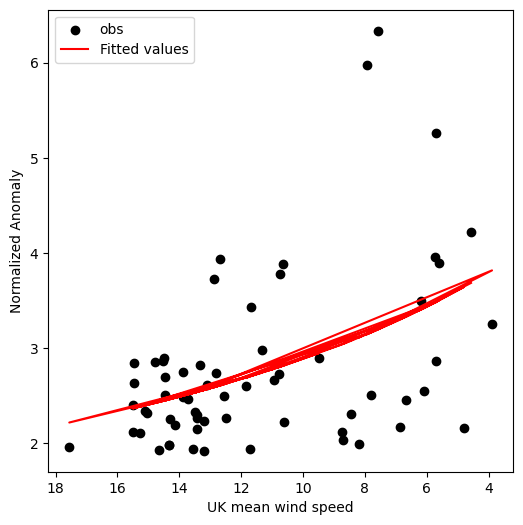

In [51]:
# now re-fit the GLM with a gamma distribution
formula = 'Normalized_Anomaly ~ UK_wind_speed'

model = smf.glm(formula=formula, data=bsuos_met_df_percentile_threshold, family=sm.families.Gamma()).fit()

# Print the model summary
print(model.summary())

# Plot the normalized anomaly values on the y-axis against the mean UK wind speed on the x-axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot of the actual data
ax.scatter(
    bsuos_met_df_percentile_threshold["UK_wind_speed"],
    bsuos_met_df_percentile_threshold["Normalized_Anomaly"],
    label="obs",
    color="black"
)

# Plot the fitted values
ax.plot(
    bsuos_met_df_percentile_threshold["UK_wind_speed"],
    model.fittedvalues,
    label="Fitted values",
    color="red"
)

# Set the labels
ax.set_xlabel("UK mean wind speed")

# Set the labels
ax.set_ylabel("Normalized Anomaly")

# Invert the x-axis to have the largest values first
ax.invert_xaxis()

# Include a legend
ax.legend()


In [52]:
# remove the row with the second highest value of normalized anomaly
bsuos_met_df_percentile_threshold = bsuos_met_df_percentile_threshold.drop(second_spike)

# and the third
bsuos_met_df_percentile_threshold = bsuos_met_df_percentile_threshold.drop(third_spike)

# and the fourth
bsuos_met_df_percentile_threshold = bsuos_met_df_percentile_threshold.drop(fourth_spike)

                 Generalized Linear Model Regression Results                  
Dep. Variable:     Normalized_Anomaly   No. Observations:                   60
Model:                            GLM   Df Residuals:                       58
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                        0.042639
Method:                          IRLS   Log-Likelihood:                -44.672
Date:                Fri, 24 Jan 2025   Deviance:                       2.3432
Time:                        14:37:06   Pearson chi2:                     2.47
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1516
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2781      0.033      8.460

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


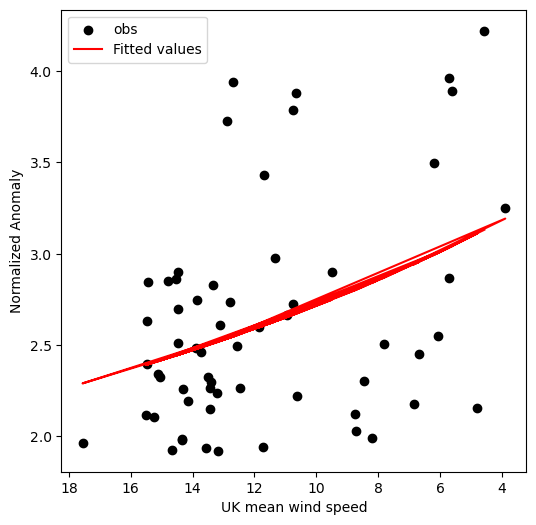

In [54]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Fit a GLM with a gamma distribution
formula = 'Normalized_Anomaly ~ UK_wind_speed'
model = smf.glm(formula=formula, data=bsuos_met_df_percentile_threshold, family=sm.families.Gamma()).fit()

# Print the model summary
print(model.summary())

# Calculate the rank correlation coefficient (Spearman's rho)
spearman_corr, p_value = spearmanr(bsuos_met_df_percentile_threshold["Normalized_Anomaly"], model.fittedvalues)
print(f"Spearman's rank correlation coefficient: {spearman_corr:.2f}, p-value: {p_value:.2e}")

# Plot the normalized anomaly values on the y-axis against the mean UK wind speed on the x-axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot of the actual data
ax.scatter(
    bsuos_met_df_percentile_threshold["UK_wind_speed"],
    bsuos_met_df_percentile_threshold["Normalized_Anomaly"],
    label="obs",
    color="black"
)

# Plot the fitted values
ax.plot(
    bsuos_met_df_percentile_threshold["UK_wind_speed"],
    model.fittedvalues,
    label="Fitted values",
    color="red"
)

# Set the labels
ax.set_xlabel("UK mean wind speed")

# Set the labels
ax.set_ylabel("Normalized Anomaly")

# Invert the x-axis to have the largest values first
ax.invert_xaxis()

# Include a legend
ax.legend()

# Show the plot
plt.show()